# Self-Attention Controllability Theorem Measurement in Llama-3 8b

In this notebook we will demonstrate the self-attention controllability theorem 
on GPT-2. 

We begin by extracting a single attention head from the model. For a given 
input token sequence x_0, we will compute the value of $\beta_i(k, \mathbf X)$, 
which should tell us which output representations $\mathbf Y^*$ are reachable 
given $k$ 

In [210]:
# Import box 
import torch 
import numpy 
import transformers 
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM
# import functional as F 
import torch.nn.functional as F

In [211]:
# constants/args
x_0 = "I am become death, destroyer of worlds."
model_name = "meta-llama/Meta-Llama-3-8B"
layer_num = 3
k = 3 # 3 control tokens
z = 0.99 # we allow control tokens with max norm Z stdevs away from the mean (super tight bc high dimension)
head_dim = 128
num_heads = 32

In [56]:
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# if on CUDA 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


In [212]:
x_0_ids = tokenizer.encode(x_0, return_tensors="pt").to(device)
# get the activations 
with torch.no_grad():
    outputs = model(x_0_ids, output_hidden_states=True)

print("Outputs keys: ", outputs.keys())

Skip norm:  False
Outputs keys:  odict_keys(['logits', 'past_key_values', 'hidden_states'])


We will use the activations corresponding to the string $x_0$ at layer 
`layer_num` as the fixed prompt input for the self-attention head. 

Observing the statistics on activations across all input vector representations 
to self-attention, we will generate a point cloud of control input
representations $\mathbf U$ subject to the constraint that all row vectors
(token representations) satisfy $\|u_i\| \leq M_u = \mu_(X_0) + z \text{std}(X_0)$ 
where $X_0$ is a set of activations sampled from self-attention inputs across 
the layers of the model. 

Note that, within a `LlamaDecoderLayer` forward pass, the input hidden states 
are normalized with `LlamaDecoderLayer.input_layernorm(hidden_states)` before 
going through the self-attention. We will compute $\mu(X_0), \text{std}(X_0)$ from 
there. 

In [213]:
print("Grabbing a single attention head, running some values thru it...")
def get_single_attn_head(model, layer_num, return_layer=False): 
    """ Given a Llama-3 type model, get the layer_num attention head. 

    Decoder layers are called `class LlamaDecoderLayer`, attention heads 
    are `class LlamaAttention`

    """
    assert type(model) == transformers.models.llama.modeling_llama.LlamaForCausalLM, "Model must be a Llama model."
    assert layer_num < len(model.model.layers), "Layer number out of bounds"
    if not return_layer: 
        return model.model.layers[layer_num].self_attn
    else: 
        return model.model.layers[layer_num].self_attn, model.model.layers[layer_num]

print(f"Grabbing a single attention head, layer from idx = {layer_num}...")
attn_head, layer = get_single_attn_head(model, layer_num, return_layer=True)

Grabbing a single attention head, running some values thru it...
Grabbing a single attention head, layer from idx = 3...


In [214]:
with torch.no_grad():
    X_0 = outputs.hidden_states[layer_num]
    X_0_normed = model.model.layers[layer_num].input_layernorm(X_0) # see LlamaDecoderLayer.forward

# set X_0_normed[:, :, head_dim:] to 0
X_0_normed[:, :, head_dim:] = 0

print("X_0_normed shape: ", X_0_normed.shape)
print("X_0_normed per-token norms: ", torch.linalg.vector_norm(X_0_normed[:, :, :head_dim], dim=-1))
with torch.no_grad():
    Y_X, _, _ = attn_head.forward(X_0_normed)

print("Y_X shape: ", Y_X.shape)
print("Y_X per-token norms: ", torch.norm(Y_X[:, :, :head_dim], dim=-1))

X_0_normed shape:  torch.Size([1, 10, 4096])
X_0_normed per-token norms:  tensor([[0.1803, 4.3042, 4.3405, 4.4721, 4.4668, 3.3445, 3.8409, 4.2928, 4.5006,
         3.5776]], device='cuda:0')
Y_X shape:  torch.Size([1, 10, 4096])
Y_X per-token norms:  tensor([[0.0619, 0.0618, 0.0617, 0.0619, 0.0619, 0.0618, 0.0619, 0.0619, 0.0620,
         0.0618]], device='cuda:0')


In [215]:
# let us compute the mean of X_0_normed and the standard deviation 
# of X_0_normed. Just the scalar mean and standard deviation. 
mean_X_0 = torch.mean(X_0_normed[:, :, :head_dim]).item()
std_X_0 = torch.std(X_0_normed[:, :, :head_dim]).item()

print("Mean of X_0_normed: ", mean_X_0)
print("Standard deviation of X_0_normed: ", std_X_0)

X_0_normed_per_token = torch.linalg.vector_norm(X_0_normed[:, :, :head_dim], dim=-1)

print("Per-token norms of X_0_normed: ", X_0_normed_per_token)
print("Mean norm over tokens: ", torch.mean(X_0_normed_per_token).item())

Mean of X_0_normed:  -0.02945779636502266
Standard deviation of X_0_normed:  0.3466133177280426
Per-token norms of X_0_normed:  tensor([[0.1803, 4.3042, 4.3405, 4.4721, 4.4668, 3.3445, 3.8409, 4.2928, 4.5006,
         3.5776]], device='cuda:0')
Mean norm over tokens:  3.7320218086242676


In [216]:
X_0_normed.shape

torch.Size([1, 10, 4096])

## Generate Point Cloud of $\mathbf U \in \mathbb R^{k\times d_{head}}$

We will sample the initial values of $\mathbf U\in \mathbb R^{k\times d_h}$ 
where $d_h$ is the dimension of a single attention head 
with each scalar entry iid $\sim \mathcal N (\mu(X_0), \text{std}(X_0))$. 

We will constrain the absolute magnitude of all row vectors in $\mathbf U$ using
projected gradient descent to constrain all $\|\mathbf u_i\|\leq M_u = z
\text{std}(\mathbf X_0)$. 

We will constrain U to only be concerned with the 1st attention head in the 
MHA (i.e., non-zero entries for only the first `head_dim=128` entries, only 
trying to control the first $d_h$ = `head_dim` = 128 entries in the output Y 
token reps).

In [217]:
import torch

def sample_U(k, z, mean_X_0, std_X_0, batch=1, head_dim=128, d_model=4096):
    """
    Samples control inputs U for interacting with the first self-attention head
    (first head_dim entries are non-zero, remaining are zero).
    """
    # Initialize U as a k x head_dim matrix of random values sampled from
    # the normal distribution centered at mean_X_0 and std_X_0
    U = torch.randn(batch, k, head_dim).to(model.device) * std_X_0 + mean_X_0


    # Concatenate a matrix of zeros of shape k x (d_model - head_dim)
    zeros = torch.zeros(batch, k, d_model - head_dim).to(model.device)
    U = torch.cat((U, zeros), dim=-1)

    return U

U = sample_U(k, z, mean_X_0, std_X_0, head_dim=head_dim, d_model=4096)
print("U shape: ", U.shape)

U shape:  torch.Size([1, 3, 4096])


In [218]:
U[0, :, 0:head_dim].std()

tensor(0.3474, device='cuda:0')

In [219]:
torch.linalg.vector_norm(U[0, :, 0:head_dim], dim=-1)

tensor([4.1133, 3.7997, 3.8848], device='cuda:0')

## Sampling from + Projecting Back to Z-score Bubble for $\mathbf U$ rows

Let's compute the norm corresponding to Z standard deviations above the average
expected norm given that the d_model = 128 scalar entries in each input vector
is smpled from $N(\mu, \text{std} )$ 

The vector is in $\mathbb R^d$, i.e., it has d elements.
Each element is independently and identically distributed (iid) according to \mathcal N(\mu, \sigma).

### Part 1: Expected norm of the vector
Let the vector be $\mathbf x = (x_1, x_2, \ldots, x_d), where x_i \sim \mathcal N(\mu, \sigma) \text{ for } i = 1, 2, \ldots, d$.
The norm of the vector $\mathbf x$ is given by:
$$
\|\mathbf x\| = \sqrt{x_1^2 + x_2^2 + \cdots + x_d^2} = \sqrt{\sum_{i=1}^d x_i^2}
$$
Now, we know that if $X \sim \mathcal N(\mu, \sigma), then \mathbb E[X^2] = \mu^2 + \sigma^2$.
Therefore, $\mathbb E[x_i^2] = \mu^2 + \sigma^2 \text{ for } i = 1, 2, \ldots, d$.

By linearity of expectation:
$$
\mathbb E\left[\sum_{i=1}^d x_i^2\right] = \sum_{i=1}^d \mathbb E[x_i^2] = d(\mu^2 + \sigma^2)
$$
Thus, the expected norm of the vector is:
$$
\mathbb E[\|\mathbf x\|] = \mathbb E\left[\sqrt{\sum_{i=1}^d x_i^2}\right] \approx \sqrt{\mathbb E\left[\sum_{i=1}^d x_i^2\right]} = \sqrt{d(\mu^2 + \sigma^2)}
$$
Note: The approximation in the last step is due to Jensen's inequality, as the square root function is concave. The approximation becomes more accurate for large d.
Part 2: Expected standard deviation across the norms of vectors
To find the expected standard deviation across the norms of vectors, we need to calculate the variance of the norm.
$$
\text{Var}(\|\mathbf x\|) = \mathbb E[\|\mathbf x\|^2] - (\mathbb E[\|\mathbf x\|])^2 
$$

$$
\approx \mathbb E\left[\sum_{i=1}^d x_i^2\right] - d(\mu^2 + \sigma^2) 
$$

$$
= d(\mu^2 + \sigma^2) - d(\mu^2 + \sigma^2) \\
$$
$$
= 0
$$
Therefore, the expected standard deviation across the norms of vectors is approximately:
$$
\sqrt{\text{Var}(\|\mathbf x\|)} \approx 0
$$
In summary, for a vector in $\mathbb R^d$ with elements iid $\mathcal N(\mu,
\sigma)$, the expected norm is approximately $\sqrt{d(\mu^2 + \sigma^2)}$, and
the expected standard deviation across the norms of vectors sampled in this
manner is approximately $0$ for large $d$.

In [220]:
import math
expected_norm = math.sqrt(head_dim *(mean_X_0**2 + std_X_0**2)) # std_X_0, mean_X_0
expected_norm
print(f"Mean expected norm of head_dim-dimensional vectors in U\n (including offset mu): ", expected_norm)

expected_norm_min_mu = math.sqrt(head_dim * (std_X_0**2))
print(f"Mean expected norm of head_dim-dimensional vectors in U\n (excluding offset mu): ", expected_norm_min_mu)

Mean expected norm of head_dim-dimensional vectors in U
 (including offset mu):  3.9356187423986957
Mean expected norm of head_dim-dimensional vectors in U
 (excluding offset mu):  3.9214820386410607


Offset $\mu$ is within 1e-3 of zero, so we will just project back to the norm ball 
scaled by $\sqrt{d_h \sigma_{X_0}^2}$

In [221]:
U = sample_U(k, z, mean_X_0, std_X_0, head_dim=head_dim, d_model=4096)
U.shape

torch.Size([1, 3, 4096])

In [222]:
def project_U(U, mean_X_0, std_X_0, z, head_dim): 
    """ Project each token in U (shape [batch, num_tok, d_model]) 
    into a distance of z standard deviations from the mean. 
    """
    print("Norms of each token rep in U: ", torch.linalg.vector_norm(U[0, :, 0:head_dim], dim=-1))

    # ensure that everything other than U[:, :, 0:head_dim] are zeros 
    U[:, :, head_dim:] = 0
    # print("U[:, :, 120:150] = ", U[:, :, 120:150])

    max_norm = math.sqrt(head_dim * (std_X_0**2)) * z
    print("Max allowable norm: ", max_norm)

    norm_mask = torch.linalg.vector_norm(U[0, :, 0:head_dim], dim=-1) > max_norm

    print(norm_mask)

    # U has shape [batch, num_tok, d_model]. We need to divide the elements with 
    # norm_mask[:, tok_num, :] /= torch.linalg.vector_norm(U[:, tok_num, 0:head_dim], dim=-1)
    # Rescale the elements exceeding the maximum norm
    for tok_num in range(k):
        if norm_mask[tok_num]:
            U[:, tok_num, :] /= torch.linalg.vector_norm(U[:, tok_num, 0:head_dim], dim=-1)
            U[:, tok_num, :] *= max_norm

    return U, max_norm 

U, M_u = project_U(U, mean_X_0, std_X_0, z, head_dim)
print("U.shape: ", U.shape)
print("Max norm: ", M_u)
print("Norms of each token rep in U: ", torch.linalg.vector_norm(U, dim=-1))

Norms of each token rep in U:  tensor([3.9357, 3.8144, 3.7736], device='cuda:0')
Max allowable norm:  3.88226721825465
tensor([ True, False, False], device='cuda:0')
U.shape:  torch.Size([1, 3, 4096])
Max norm:  3.88226721825465
Norms of each token rep in U:  tensor([[3.8823, 3.8144, 3.7736]], device='cuda:0')


Projection and generation of $U$ seems to be working! Let's compute our $\beta(k, \mathbf X_0)$ 
bounds and show we can't budget $Y_X$ more than $\beta(k, \mathbf X_0)$ using $U$

## Computing $\beta(k, \mathbf X_0)$ 

$$ 
\|Y_{u\perp}^i\| \leq \|Y_u^i\| \leq \beta_i(k, \mathbf X_0) = \frac{k e^\alpha}{g_i(\mathbf X_0) + ke^\alpha}
$$

Where 
 - $k$ is the number of control input tokens. 
 - $\alpha = \sigma_q \sigma_v M_u M_x / \sqrt{d_k}$
 - $C = \sigma_v M_u$
 - $g_i(X) = D_{xx}^i = \exp(\frac{X W_q W_k^T X^T}{\sqrt{d_k}}) \mathbb 1_{m\times 1}$ is the denominator term in the softmax corresponding to $X_0$.



Since we are using only the first d_head = 128 indices of token representation vectors, we will only use the first d_head = 128 rows of the W_q, W_k projection matrices when we compute the maximal singular values. 



In [223]:
W_q = attn_head.q_proj.weight[:head_dim, :] # only the first head :) 
W_v = attn_head.v_proj.weight[:head_dim, :] # only the first head :)
W_k = attn_head.k_proj.weight[:head_dim, :] # only the first head :)

print("W_q, W_k, W_v shape: ", W_q.shape)

svd_q = torch.linalg.svdvals(W_q)
svd_k = torch.linalg.svdvals(W_k)
svd_v = torch.linalg.svdvals(W_v)

sigma_q = torch.max(svd_q).item()
sigma_k = torch.max(svd_k).item()
sigma_v = torch.max(svd_v).item()

M_x = torch.linalg.norm(X_0_normed, dim=-1).max().item()
print("M_x: ", M_x)
print("M_u: ", M_u)

alpha = sigma_q * sigma_v * M_u * M_x / (math.sqrt(head_dim))
print("Alpha: ", alpha)

print("Sigma_q, Sigma_k, Sigma_v: ", sigma_q, sigma_k, sigma_v)

W_q, W_k, W_v shape:  torch.Size([128, 4096])
M_x:  4.500611782073975
M_u:  3.88226721825465
Alpha:  2.485822248543153
Sigma_q, Sigma_k, Sigma_v:  2.498584747314453 3.360649824142456 0.64420485496521


In [224]:
print("Number of heads: ", attn_head.num_heads)
print("Head dimension: ", attn_head.head_dim)
print("Number of key-value heads: ", attn_head.num_key_value_heads)
print("hidden size: ", attn_head.hidden_size)

print("\nKeys, values get projected from 4096 to ", attn_head.num_key_value_heads * attn_head.head_dim)
print("Queries get projected from 4096 to ", attn_head.num_heads * attn_head.head_dim)
print("Number of key value groups (4?): ", attn_head.num_key_value_groups)

Number of heads:  32
Head dimension:  128
Number of key-value heads:  8
hidden size:  4096

Keys, values get projected from 4096 to  1024
Queries get projected from 4096 to  4096
Number of key value groups (4?):  4


That means that we re-use the same key-queries by stacking them 4 times.

The `repeat_kv()` function appears to emit tensors of shape `[batch, num_key_value_heads * (n_rep=4), slen, head_dim]`

8 key_value heads * 4 reps = 32 as 2nd dimension (number of heads) 

So basically `num_key_value_heads` is just `dim_head / num_key_value_groups`

For the first head, we really do just need the first `dim_head` = 128 columns 
of the key and query projection matrices to compute the singular values for 
our single-head example. We already do this, so we're ready to compute the 
$g(X)$ coefficients. We will also confirm these match with the attention output. 

In [225]:
X = X_0_normed[:, :, :128]
X.shape

torch.Size([1, 10, 128])

In [237]:
def get_g_X0(X, W_q, W_k, d_k): 
    """
    X: [batch=1, num_toks, d_head=128]
    """
    print("Shape of X (batch=1, num_toks, d_head=128): ", X.shape)
    print("Shape of W_q: ", W_q.shape)
    print("Shape of W_k: ", W_k.shape)
    print("d_k: ", d_k)

    # now let's linearly project X thru W_q, W_k with torch.nn.functional 
    Q = F.linear(X, W_q[:head_dim, :head_dim]) # [1, num_toks, 128]
    K = F.linear(X, W_k[:head_dim, :head_dim]) # [1, num_toks, 128]
    print("Q shape: ", Q.shape)
    print("K shape: ", K.shape)

    A_xx = torch.einsum('ijk, ilk->ijl', Q, K) / math.sqrt(d_k)
    exp_A_xx = torch.exp(A_xx)

    print(A_xx.shape)
    # multiply by an [M, 1] vector 
    m = A_xx.shape[1]
    assert m == A_xx.shape[2]

    # make the vector of ones 
    ones_ = torch.ones(m, 1).to(X.device)

    gX0_i = exp_A_xx @ ones_

    return gX0_i


gX0_i = get_g_X0(X, W_q, W_k, d_k=head_dim) # according to LlamaAttention.forward, sqrt(head_dim) takes the place of sqrt(d_k)
print(gX0_i.shape)
print(gX0_i)


Shape of X (batch=1, num_toks, d_head=128):  torch.Size([1, 10, 128])
Shape of W_q:  torch.Size([128, 4096])
Shape of W_k:  torch.Size([128, 4096])
d_k:  128
Q shape:  torch.Size([1, 10, 128])
K shape:  torch.Size([1, 10, 128])
torch.Size([1, 10, 10])
torch.Size([1, 10, 1])
tensor([[[10.0000],
         [10.0032],
         [10.0046],
         [10.0955],
         [10.0070],
         [10.0015],
         [10.0529],
         [10.0342],
         [10.0171],
         [ 9.9921]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)


To get a sense of the controllability of the final token representation, let's 
compute $beta_{i=m}(k, \mathbf X_0)$ using $g_{i=m}(X_0)$

In [238]:
g_i = gX0_i[0, -1, 0].item()
print("g_i: ", g_i)

g_i:  9.992090225219727


In [240]:
beta_i = k* math.exp(alpha) / (g_i + k *math.exp(alpha))
print("Beta_i: ", beta_i)

Beta_i:  0.7828989525989672


Now that we've found beta_i, we're ready to demonstrate that $\| Y_u ^i \| \leq
\beta_i(k, \mathbf X_0)$, we're ready to compute $Y_u$ and $Y_x^{min,max}$ 
for various random $U$ and show that we cannot deviate $Y_x$ outside a ball 
of radius $\beta_i(k, X_0)$ using $k$ tokens subject to norm limit $M_u$ on 
rows of $U$. 

In [ ]:
# TODO 

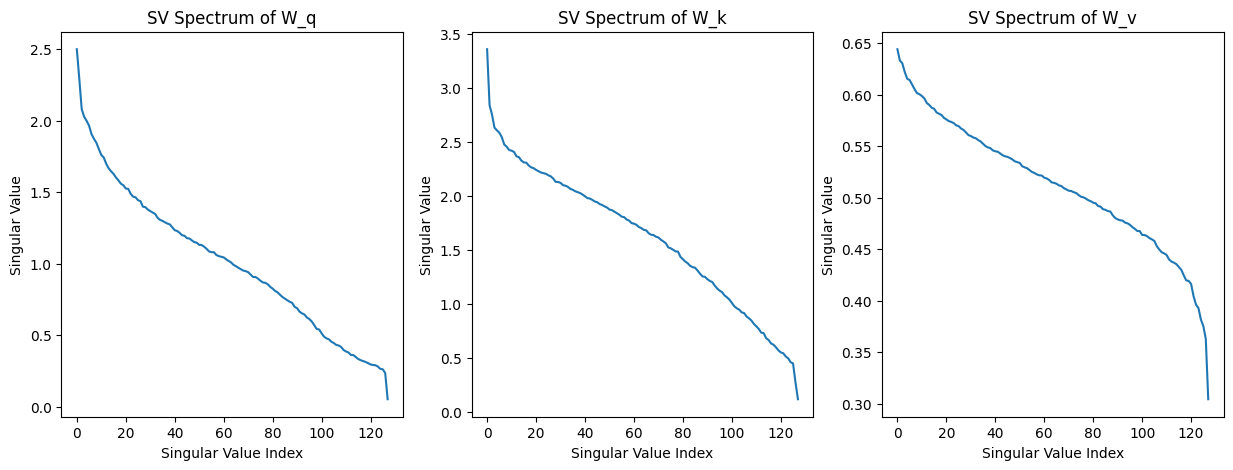

In [241]:
# plot the svd spectrum for each of the weight matrices
# make a 1 x 3 plot 
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(svd_q.detach().cpu())
axs[0].set_title("SV Spectrum of W_q")
# axis labels
axs[0].set_xlabel("Singular Value Index")
axs[0].set_ylabel("Singular Value")


axs[1].plot(svd_k.detach().cpu())
axs[1].set_title("SV Spectrum of W_k")
#axis labels 
axs[1].set_xlabel("Singular Value Index")
axs[1].set_ylabel("Singular Value")


axs[2].plot(svd_v.detach().cpu())
axs[2].set_title("SV Spectrum of W_v")
# axis labels
axs[2].set_xlabel("Singular Value Index")
axs[2].set_ylabel("Singular Value")

plt.show()


In [110]:
import torch.nn.functional as F 
F.linear(U, attn_head.q_proj.weight[:head_dim, :]).shape # this is correct

torch.Size([1, 3, 128])

In [197]:
U.shape

torch.Size([1, 3, 4096])

In [107]:
attn_head.q_proj.weight.shape

torch.Size([4096, 4096])

In [106]:
attn_head.q_proj(U)

tensor([[[-0.0541, -0.0293, -0.0625,  ..., -0.0033, -0.0927, -0.0120],
         [ 0.0206, -0.0110,  0.0523,  ..., -0.0155,  0.1214,  0.1070],
         [ 0.0066, -0.0369,  0.0131,  ..., -0.1601,  0.0552,  0.1523]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>)

Hell yeah